# **2110433 - Computer Vision (2023/2)**
#**Lab 9 - Modern Object Detection [Homework]** <br>
In this lab, we will learn how to use MMDetection to perform object detection in the provided real world dataset using PyTorch. This notebook includes both coding and written questions. Please hand in this notebook file with all outputs and your answer.

**Collaboration is encouraged in this course.** You must turn in your own write ups of all problems. If you collaborate with others, you must put the names and ids of the students you worked with in below block.

Collaboration List:
- ...
- ...


# Assignment 1 : Parasite Detection
![alt text](https://icip2022challenge.piclab.ai/wp-content/uploads/2022/01/parasite_egg_11_with_size.png)

In this assignment you have to replace YOUR_STUDENT_ID_WITH21 variable with your student id (in integer). There will be 2 sets of data: train and test

By using the knowledge from the lab and lecture, you have to train object detection model and tested on unknown label dataset!



Scoreboard URL : https://www.piclab.ai/classes/cv2023/lab9/scoreboard

### Hints
- The parasite dataset was created using COCO dataset format
- If you use MMDetection, the dataset is ready to use
- If you want to use Ultralytics, you have to format to YOLO dataset format (use Fiftyone!)


## GPU Status Check

In [1]:
!nvidia-smi

Sun Mar 31 18:50:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        On  | 00000000:01:00.0  On |                  N/A |
| 65%   44C    P8              26W / 340W |    668MiB / 16376MiB |     17%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Download and inspect parasite dataset

In [2]:
# !pip install --upgrade gdown
# !gdown https://drive.google.com/uc?id=1RVluBzZvJ8mWwA5AuB2PklbaoK60uPMF
# !gdown https://drive.google.com/uc?id=1kvBxmC1o0vE2ef2CJqhLaj9V4TD72oW3
# !unzip parasite_train.zip
# !unzip parasite_test.zip

## Your model description goes here: ###
WRITE HERE

### Dataset Exploration
We will use pycocotools to explore this dataset.

In [3]:
from pycocotools.coco import COCO
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [4]:
trainLabelFile='./parasite_train/labels.json'
# initialize COCO api for instance annotations
trainCOCOBinding = COCO(trainLabelFile)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


COCO categories: 
Capillaria philippinensis, Enterobius vermicularis, Hymenolepis diminuta, Hymenolepis nana, Paragonimus spp

['Capillaria philippinensis', 'Enterobius vermicularis', 'Hymenolepis diminuta', 'Hymenolepis nana', 'Paragonimus spp']
[601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 75

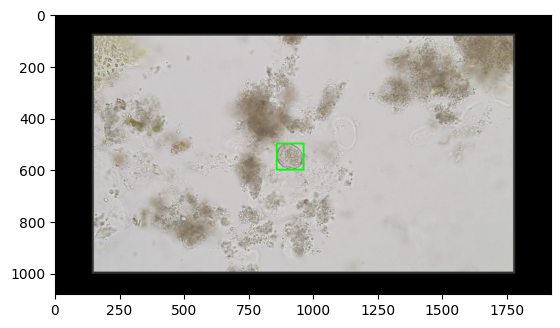

In [5]:
#display COCO categories and supercategories
cats = trainCOCOBinding.loadCats(trainCOCOBinding.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(', '.join(nms)))
print(nms)

# get all images containing given categories, select one at random
catIds = trainCOCOBinding.getCatIds(catNms=['Hymenolepis diminuta',]);
imgIds = trainCOCOBinding.getImgIds(catIds=catIds );
print([id for id in imgIds])

randomImgId = np.random.randint(0,len(imgIds))
sampleImageData = trainCOCOBinding.loadImgs(randomImgId)[0]

print('Image Data >>', sampleImageData)

sampleImage = cv2.imread('parasite_train/data/'+sampleImageData['file_name'])

annIds = trainCOCOBinding.getAnnIds(imgIds=randomImgId, iscrowd=None)
boxes = trainCOCOBinding.loadAnns(annIds)
print('Box Data', boxes)

for box in boxes:
  x,y,w,h = box['bbox']
  cv2.rectangle(sampleImage, (int(x), int(y)), (int(x+w), int(y+h)), (0,255,0), 5)

sampleImage = cv2.cvtColor(sampleImage, cv2.COLOR_BGR2RGB)

plt.imshow(sampleImage)
plt.show()

### Training

In [6]:
from ultralytics import YOLO
import torch

torch.cuda.empty_cache()

yolo_model = YOLO('yolov8l.yaml').load('yolov8l.pt')
# yolo_model = YOLO('./runs/detect/train11/weights/best.pt').load('./runs/detect/train11/weights/best.pt')
yolo_model = yolo_model.cuda()
config = {
    'data' : 'dataset.yaml',
    'epochs' : 150,
    'batch' : 8,
    'device' : 0,
    'workers' : 20,
    'verbose' : True,
    # 'max_det' : 1,
    'imgsz' : 1152
}

Transferred 595/595 items from pretrained weights


In [7]:
yolo_model.train(**config)

New https://pypi.org/project/ultralytics/8.1.38 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.37 🚀 Python-3.11.8 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4080, 16071MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.yaml, data=dataset.yaml, epochs=150, time=None, patience=100, batch=8, imgsz=1152, save=True, save_period=-1, cache=False, device=0, workers=20, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save

train: Scanning /home/andre/Desktop/CU_submission/chulacv2023/Lab9/student/train/labels/val.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
val: Scanning /home/andre/Desktop/CU_submission/chulacv2023/Lab9/student/train/labels/val.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


Plotting labels to runs/detect/train12/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1152 train, 1152 val
Using 20 dataloader workers
Logging results to runs/detect/train12
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      15.4G     0.5618      2.679     0.9569         10       1152: 100%|██████████| 125/125 [00:49<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13<00:00,  4.79it/s]

                   all       1000       1000      0.722       0.58      0.707      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      15.7G     0.6633      1.611      1.031         16       1152: 100%|██████████| 125/125 [00:48<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13<00:00,  4.75it/s]

                   all       1000       1000      0.316      0.275      0.198      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      15.7G     0.6754      1.363      1.034         13       1152: 100%|██████████| 125/125 [00:47<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.21it/s]

                   all       1000       1000      0.754        0.5      0.584      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      15.7G     0.6543      1.149      1.024         12       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.30it/s]

                   all       1000       1000      0.769      0.784      0.875      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      15.8G      0.628     0.9837      1.012         13       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.28it/s]

                   all       1000       1000      0.851      0.788      0.871       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      15.7G     0.5915     0.8201     0.9931         22       1152: 100%|██████████| 125/125 [00:46<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.30it/s]

                   all       1000       1000      0.833      0.792      0.872      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      15.7G     0.5565     0.7454     0.9501         15       1152: 100%|██████████| 125/125 [00:45<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.30it/s]

                   all       1000       1000      0.779      0.715      0.777      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      15.7G     0.5825     0.7796     0.9813         17       1152: 100%|██████████| 125/125 [00:45<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.32it/s]

                   all       1000       1000      0.909      0.859       0.93      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      15.7G     0.5485     0.7045     0.9714         13       1152: 100%|██████████| 125/125 [00:45<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.28it/s]

                   all       1000       1000      0.813      0.737       0.84      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      15.7G     0.5177     0.6625     0.9421         19       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.31it/s]

                   all       1000       1000      0.853      0.884      0.937      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      15.7G     0.5057     0.6292     0.9388         11       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.30it/s]

                   all       1000       1000      0.855      0.741      0.867      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      15.7G     0.4946     0.6053     0.9333         15       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.32it/s]

                   all       1000       1000      0.916      0.872      0.948      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      15.7G     0.4733     0.5801      0.927         13       1152: 100%|██████████| 125/125 [00:45<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.30it/s]

                   all       1000       1000      0.872        0.9      0.938      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      15.7G     0.4764     0.5396     0.9231         19       1152: 100%|██████████| 125/125 [00:45<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.28it/s]

                   all       1000       1000      0.898       0.92      0.961      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      15.8G     0.4474     0.4878     0.9206         19       1152: 100%|██████████| 125/125 [00:45<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.32it/s]

                   all       1000       1000      0.935      0.952       0.98      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      15.8G     0.4735     0.5114      0.926         19       1152: 100%|██████████| 125/125 [00:46<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.33it/s]

                   all       1000       1000       0.94      0.931      0.978      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      15.7G     0.4276     0.4822     0.8991         12       1152: 100%|██████████| 125/125 [00:45<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.34it/s]

                   all       1000       1000      0.928      0.953      0.981      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      15.7G     0.4267     0.4495     0.9039         10       1152: 100%|██████████| 125/125 [00:45<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.34it/s]

                   all       1000       1000      0.945      0.967      0.984      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      15.7G     0.4481     0.4504     0.9131         14       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.33it/s]

                   all       1000       1000      0.858      0.884      0.957      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      15.7G     0.4294     0.4345     0.9184         11       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.32it/s]

                   all       1000       1000      0.933      0.951      0.975      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      15.6G     0.4183     0.4478     0.9018         15       1152: 100%|██████████| 125/125 [00:45<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.27it/s]

                   all       1000       1000      0.927       0.95       0.98      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      15.6G     0.4092     0.4288     0.8926         13       1152: 100%|██████████| 125/125 [00:45<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.29it/s]

                   all       1000       1000      0.944      0.927      0.981       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      15.6G       0.42     0.4523     0.9129         21       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.31it/s]

                   all       1000       1000       0.97      0.972      0.989      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      15.6G     0.4048     0.4128        0.9         13       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.29it/s]

                   all       1000       1000      0.978      0.984      0.992      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      15.7G     0.4055     0.4031     0.8953         12       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.27it/s]

                   all       1000       1000      0.953      0.959      0.986      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      15.7G      0.401     0.3678     0.8941         13       1152: 100%|██████████| 125/125 [00:45<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.34it/s]

                   all       1000       1000       0.95       0.96      0.985      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      15.7G     0.4143     0.3997     0.8997         16       1152: 100%|██████████| 125/125 [00:45<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.29it/s]

                   all       1000       1000       0.91      0.913      0.972      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      15.7G     0.3855     0.3787     0.8781         16       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.30it/s]

                   all       1000       1000      0.967      0.975      0.987      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      15.6G     0.3959     0.3807     0.8968         17       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.29it/s]

                   all       1000       1000       0.96      0.968      0.984      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      15.6G     0.3965     0.3794     0.8871         23       1152: 100%|██████████| 125/125 [00:45<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.34it/s]

                   all       1000       1000      0.963      0.956      0.987      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      15.7G     0.3796     0.3542       0.88         15       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.29it/s]

                   all       1000       1000      0.981      0.981      0.992       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      15.7G     0.3811     0.3531     0.8847         23       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.33it/s]

                   all       1000       1000      0.979      0.992      0.993      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      15.7G     0.3814     0.3509     0.8749         16       1152: 100%|██████████| 125/125 [00:45<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.31it/s]

                   all       1000       1000      0.973      0.985      0.989      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      15.7G     0.3628     0.3279     0.8843         19       1152: 100%|██████████| 125/125 [00:45<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.29it/s]

                   all       1000       1000      0.982      0.996      0.993      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      15.7G     0.3624     0.3298     0.8773          9       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.33it/s]

                   all       1000       1000      0.985      0.984      0.992      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      15.7G     0.3701     0.3332     0.8751         14       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.34it/s]

                   all       1000       1000      0.948      0.958      0.982      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      15.6G     0.3714     0.3462     0.8834         15       1152: 100%|██████████| 125/125 [00:45<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.34it/s]

                   all       1000       1000      0.984      0.977      0.993      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      15.7G     0.3639     0.3178     0.8685         15       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.28it/s]

                   all       1000       1000      0.934       0.92      0.968       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      15.6G     0.3624     0.3174     0.8757          8       1152: 100%|██████████| 125/125 [00:45<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.34it/s]

                   all       1000       1000      0.979      0.991      0.994      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      15.8G     0.3586     0.3073     0.8812         15       1152: 100%|██████████| 125/125 [00:45<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.32it/s]

                   all       1000       1000      0.974      0.986      0.991      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      15.7G     0.3496      0.326     0.8676         16       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.33it/s]

                   all       1000       1000      0.944      0.963      0.983      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      15.7G     0.3553     0.3307     0.8764         18       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.28it/s]

                   all       1000       1000      0.985      0.995      0.992      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      15.7G     0.3512     0.3266     0.8698         10       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.33it/s]

                   all       1000       1000      0.983      0.989      0.992      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      15.7G     0.3515     0.3082     0.8735         17       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.29it/s]

                   all       1000       1000       0.99      0.997      0.993      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      15.7G     0.3366     0.2948     0.8687         10       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.37it/s]

                   all       1000       1000      0.991      0.996      0.994      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      15.7G     0.3474     0.2945     0.8602          9       1152: 100%|██████████| 125/125 [00:45<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.29it/s]

                   all       1000       1000      0.989      0.992      0.993      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      15.7G     0.3416     0.3003     0.8643         16       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.34it/s]

                   all       1000       1000      0.991      0.995      0.993       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      15.8G     0.3417      0.285     0.8614          9       1152: 100%|██████████| 125/125 [00:45<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.34it/s]

                   all       1000       1000       0.99      0.997      0.993      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      15.7G     0.3441      0.293      0.877         10       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.31it/s]

                   all       1000       1000      0.991      0.998      0.995      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      15.7G     0.3378     0.2898     0.8675         17       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.31it/s]

                   all       1000       1000      0.987      0.989      0.993      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      15.7G     0.3421     0.2963     0.8713         14       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.32it/s]

                   all       1000       1000      0.979      0.989      0.992      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      15.7G      0.337     0.2972     0.8709         15       1152: 100%|██████████| 125/125 [00:45<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.30it/s]

                   all       1000       1000       0.95      0.967      0.988      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      15.6G     0.3322      0.277     0.8595         12       1152: 100%|██████████| 125/125 [00:45<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.29it/s]

                   all       1000       1000      0.988      0.988      0.994      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      15.7G     0.3394     0.2803     0.8701         16       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.30it/s]

                   all       1000       1000      0.982      0.989      0.993      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      15.7G     0.3355     0.2872     0.8681         12       1152: 100%|██████████| 125/125 [00:45<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.29it/s]

                   all       1000       1000      0.982      0.992      0.993      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      15.7G     0.3333     0.2853     0.8675         12       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]

                   all       1000       1000      0.989      0.997      0.991      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      15.7G     0.3275     0.2759     0.8645         19       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.00it/s]

                   all       1000       1000      0.987      0.987      0.993      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      15.7G     0.3307     0.2658     0.8646         11       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]

                   all       1000       1000      0.993      0.997      0.994      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      15.7G     0.3326      0.273      0.862         18       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.00it/s]

                   all       1000       1000      0.992      0.998      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      15.7G     0.3296      0.282     0.8693         15       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.00it/s]

                   all       1000       1000       0.99      0.994      0.993      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      15.6G     0.3221     0.2639      0.866         19       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]

                   all       1000       1000       0.97       0.97      0.983      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      15.6G     0.3324     0.2787     0.8636         19       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.05it/s]

                   all       1000       1000      0.994      0.996      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      15.6G     0.3209     0.2513     0.8596         11       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]

                   all       1000       1000      0.994      0.999      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      15.6G     0.3245     0.2537     0.8605         18       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]

                   all       1000       1000      0.993      0.998      0.995      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      15.6G     0.3199     0.2478     0.8536         11       1152: 100%|██████████| 125/125 [00:46<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  4.99it/s]

                   all       1000       1000       0.99      0.998      0.994      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      15.7G     0.3146      0.245     0.8616         21       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.06it/s]

                   all       1000       1000      0.995      0.999      0.994      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      15.7G     0.3091     0.2537     0.8455         17       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  4.99it/s]

                   all       1000       1000      0.989      0.997      0.994      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      15.7G     0.3058     0.2483     0.8454         16       1152: 100%|██████████| 125/125 [00:46<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]

                   all       1000       1000      0.994      0.996      0.994      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      15.7G       0.31     0.2412     0.8474          9       1152: 100%|██████████| 125/125 [00:46<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.06it/s]

                   all       1000       1000      0.989      0.995      0.994       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      15.6G     0.3025     0.2428     0.8402         14       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.00it/s]

                   all       1000       1000      0.989      0.995      0.993      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      15.7G     0.3088     0.2393      0.854          9       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]

                   all       1000       1000       0.98      0.977      0.992      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      15.6G     0.2979     0.2363     0.8435         16       1152: 100%|██████████| 125/125 [00:46<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.01it/s]

                   all       1000       1000      0.991      0.998      0.994      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      15.7G     0.3036     0.2405     0.8535         11       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.04it/s]

                   all       1000       1000      0.996      0.996      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      15.7G     0.3069     0.2389     0.8546         19       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]

                   all       1000       1000      0.993      0.998      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      15.7G     0.2953     0.2316     0.8433         13       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]

                   all       1000       1000      0.997      0.998      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      15.7G     0.2853     0.2335     0.8393         14       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]

                   all       1000       1000      0.994      0.995      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      15.6G     0.2983     0.2356     0.8506         13       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.01it/s]

                   all       1000       1000      0.994      0.996      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      15.7G     0.2975     0.2357     0.8518         21       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.04it/s]

                   all       1000       1000      0.994      0.998      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      15.7G     0.2997     0.2318     0.8467         14       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.00it/s]

                   all       1000       1000      0.993          1      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      15.6G     0.2994     0.2288     0.8488         14       1152: 100%|██████████| 125/125 [00:46<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.01it/s]

                   all       1000       1000      0.995      0.995      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      15.7G     0.2871     0.2286     0.8381         10       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.00it/s]

                   all       1000       1000      0.996          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      15.7G     0.2957     0.2208      0.845         18       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]

                   all       1000       1000      0.993      0.997      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      15.7G     0.2955     0.2285     0.8471         15       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.04it/s]

                   all       1000       1000      0.994          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      15.7G     0.2933     0.2212     0.8452         16       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  4.98it/s]

                   all       1000       1000      0.996          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      15.6G     0.2906     0.2213     0.8425         13       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.01it/s]

                   all       1000       1000      0.994      0.998      0.994      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      15.8G     0.2888     0.2217     0.8411         12       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.06it/s]

                   all       1000       1000      0.994      0.998      0.994      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      15.7G     0.2909     0.2159     0.8446         10       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]

                   all       1000       1000      0.991      0.999      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      15.7G     0.2803     0.2101     0.8416         13       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]

                   all       1000       1000      0.994      0.997      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      15.7G     0.2802     0.2179     0.8477         12       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]

                   all       1000       1000      0.997      0.996      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      15.7G     0.2792     0.2135     0.8414         29       1152: 100%|██████████| 125/125 [00:46<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]

                   all       1000       1000      0.996          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      15.7G     0.2793     0.2113     0.8361         14       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.00it/s]

                   all       1000       1000      0.998      0.999      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      15.7G     0.2822     0.2108     0.8445         15       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.00it/s]

                   all       1000       1000      0.996      0.998      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      15.6G     0.2727     0.2084     0.8386         17       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]

                   all       1000       1000      0.996          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      15.7G     0.2696     0.2009     0.8399          9       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.00it/s]

                   all       1000       1000      0.994      0.997      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      15.7G     0.2729     0.2093     0.8291         10       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  4.99it/s]

                   all       1000       1000      0.996          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      15.7G     0.2731      0.202     0.8362         12       1152: 100%|██████████| 125/125 [00:46<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.04it/s]

                   all       1000       1000      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      15.7G     0.2745     0.2078     0.8344         16       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.01it/s]

                   all       1000       1000      0.996          1      0.994      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      15.7G     0.2755     0.2102     0.8445         10       1152: 100%|██████████| 125/125 [00:46<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.00it/s]

                   all       1000       1000      0.997          1      0.994      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      15.7G     0.2691     0.2057     0.8329         10       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]

                   all       1000       1000      0.998      0.999      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      15.7G     0.2599      0.197     0.8347         10       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.04it/s]

                   all       1000       1000      0.996      0.999      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      15.6G     0.2666      0.205     0.8418         15       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.04it/s]

                   all       1000       1000      0.998          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      15.7G     0.2655     0.1957     0.8362         20       1152: 100%|██████████| 125/125 [00:46<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.00it/s]

                   all       1000       1000      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      15.8G     0.2589      0.191     0.8278         23       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]

                   all       1000       1000      0.996      0.999      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      15.6G     0.2734     0.2084     0.8409         19       1152: 100%|██████████| 125/125 [00:46<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]

                   all       1000       1000      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      15.7G     0.2549     0.1976     0.8412         14       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.04it/s]

                   all       1000       1000      0.998          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      15.7G     0.2523     0.1872     0.8288         14       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.00it/s]

                   all       1000       1000      0.996      0.999      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      15.7G     0.2551     0.1866     0.8235         13       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  4.99it/s]

                   all       1000       1000      0.994      0.999      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      15.7G     0.2595     0.1974     0.8301         14       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]

                   all       1000       1000      0.997          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      15.7G     0.2528     0.1858     0.8244         14       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  4.99it/s]

                   all       1000       1000      0.997          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      15.8G     0.2525     0.1824      0.827         12       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.04it/s]

                   all       1000       1000      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      15.6G     0.2495     0.1828     0.8302         13       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.01it/s]

                   all       1000       1000      0.998          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      15.7G     0.2559      0.189      0.827         18       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  4.99it/s]

                   all       1000       1000      0.996          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      15.7G     0.2557     0.1818     0.8292         21       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.00it/s]

                   all       1000       1000      0.994      0.998      0.994      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      15.7G     0.2545     0.1835     0.8353         14       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]

                   all       1000       1000      0.996      0.999      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      15.7G     0.2441     0.1776     0.8277         11       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]

                   all       1000       1000      0.998          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      15.7G     0.2466     0.1796     0.8276         11       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.05it/s]

                   all       1000       1000      0.998          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      15.6G     0.2465      0.184      0.832         17       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  4.98it/s]

                   all       1000       1000      0.998          1      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      15.6G     0.2448     0.1822     0.8194         12       1152: 100%|██████████| 125/125 [00:46<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.00it/s]

                   all       1000       1000      0.998          1      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      15.8G     0.2505     0.1851     0.8294         15       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]

                   all       1000       1000      0.998          1      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      15.6G     0.2518     0.1867      0.823         16       1152: 100%|██████████| 125/125 [00:46<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.00it/s]

                   all       1000       1000      0.998          1      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      15.7G     0.2402     0.1764     0.8279         18       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  4.98it/s]

                   all       1000       1000      0.998          1      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      15.7G     0.2477     0.1795     0.8321          8       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.05it/s]

                   all       1000       1000      0.997          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      15.7G     0.2343     0.1708     0.8194         21       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.01it/s]

                   all       1000       1000      0.997          1      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      15.7G     0.2386     0.1791     0.8243         15       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.04it/s]

                   all       1000       1000      0.998          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      15.6G     0.2423     0.1688     0.8243         15       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  4.97it/s]

                   all       1000       1000      0.997          1      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      15.7G     0.2431     0.1786     0.8197         12       1152: 100%|██████████| 125/125 [00:45<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.36it/s]

                   all       1000       1000      0.998          1      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      15.7G     0.2347     0.1671       0.82         10       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.26it/s]

                   all       1000       1000      0.998          1      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      15.6G     0.2327     0.1631     0.8169         12       1152: 100%|██████████| 125/125 [00:46<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.36it/s]

                   all       1000       1000      0.998          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      15.7G      0.243     0.1684       0.83         19       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.33it/s]

                   all       1000       1000      0.998          1      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      15.7G     0.2337     0.1613     0.8277         19       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.33it/s]

                   all       1000       1000      0.998          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      15.7G     0.2335      0.167     0.8211         16       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.34it/s]

                   all       1000       1000      0.998          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      15.7G      0.229      0.166     0.8169         15       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.30it/s]

                   all       1000       1000      0.999          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      15.6G     0.2289     0.1563     0.8195         18       1152: 100%|██████████| 125/125 [00:45<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.26it/s]

                   all       1000       1000      0.998          1      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      15.7G     0.2249     0.1594      0.814         12       1152: 100%|██████████| 125/125 [00:45<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.33it/s]

                   all       1000       1000      0.998          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      15.7G     0.2212     0.1577     0.8201         17       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.37it/s]

                   all       1000       1000      0.998          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      15.8G     0.2198      0.155     0.8112         10       1152: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.37it/s]

                   all       1000       1000      0.998          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      15.7G     0.2212     0.1534     0.8125         17       1152: 100%|██████████| 125/125 [00:45<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.29it/s]

                   all       1000       1000      0.999          1      0.995      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      15.7G     0.2163       0.15     0.8152         11       1152: 100%|██████████| 125/125 [00:46<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.36it/s]

                   all       1000       1000      0.999          1      0.995      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      15.7G     0.2248     0.1566     0.8196         14       1152: 100%|██████████| 125/125 [00:46<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.13it/s]

                   all       1000       1000      0.998          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      15.7G       0.22     0.1509      0.825         18       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.40it/s]

                   all       1000       1000      0.998          1      0.995      0.993


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      15.7G      0.183     0.1296     0.7879          8       1152: 100%|██████████| 125/125 [00:44<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.29it/s]

                   all       1000       1000      0.998          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      15.7G     0.1812       0.13     0.7785          8       1152: 100%|██████████| 125/125 [00:45<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.29it/s]

                   all       1000       1000      0.999          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      15.7G     0.1816     0.1286     0.7857          8       1152: 100%|██████████| 125/125 [00:45<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.42it/s]

                   all       1000       1000      0.999          1      0.995      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      15.7G     0.1833     0.1261     0.7879          8       1152: 100%|██████████| 125/125 [00:44<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.48it/s]

                   all       1000       1000      0.999          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      15.7G     0.1755     0.1255     0.7879          8       1152: 100%|██████████| 125/125 [00:44<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.35it/s]

                   all       1000       1000      0.999          1      0.995      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      15.7G     0.1764     0.1217      0.782          8       1152: 100%|██████████| 125/125 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.35it/s]

                   all       1000       1000      0.999          1      0.995      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      15.7G     0.1743     0.1218     0.7862          8       1152: 100%|██████████| 125/125 [00:47<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.32it/s]

                   all       1000       1000      0.999          1      0.995      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      15.7G     0.1738     0.1224     0.7801          8       1152: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.40it/s]

                   all       1000       1000      0.999          1      0.995      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      15.7G     0.1712     0.1197     0.7857          8       1152: 100%|██████████| 125/125 [00:46<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]

                   all       1000       1000      0.999          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      15.7G     0.1717     0.1196       0.78          8       1152: 100%|██████████| 125/125 [00:48<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.32it/s]

                   all       1000       1000      0.999          1      0.995      0.994



150 epochs completed in 2.474 hours.
Optimizer stripped from runs/detect/train12/weights/last.pt, 87.7MB
Optimizer stripped from runs/detect/train12/weights/best.pt, 87.7MB

Validating runs/detect/train12/weights/best.pt...
Ultralytics YOLOv8.1.37 🚀 Python-3.11.8 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4080, 16071MiB)
YOLOv8l summary (fused): 268 layers, 43610463 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


                   all       1000       1000      0.999          1      0.995      0.994
Capillaria philippinensis       1000        200          1          1      0.995      0.992
Enterobius vermicularis       1000        200      0.999          1      0.995      0.994
  Hymenolepis diminuta       1000        200          1          1      0.995      0.995
      Hymenolepis nana       1000        200          1          1      0.995      0.995
       Paragonimus spp       1000        200      0.995          1      0.995      0.995
Speed: 0.2ms preprocess, 10.1ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train12


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x76bac8141650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

### Inference on test set!

In [8]:
# train8 l-e50-s800-b16
# train9 l-e50-s512/b32 failed
# train11 l-e50-s1152-b8
# train12 l-e150-s1152-b8

bestModel = YOLO('runs/detect/train12/weights/best.pt')

In [9]:
def convertXcYcWH(xc, yc, w, h):
    xmin = xc - w/2
    ymin = yc - h/2
    return xmin, ymin, w, h


image 1/1 /home/andre/Desktop/CU_submission/chulacv2023/Lab9/student/test/data/Hymenolepis nana_0727.jpg: 672x1152 1 Hymenolepis nana, 63.9ms
Speed: 2.5ms preprocess, 63.9ms inference, 0.7ms postprocess per image at shape (1, 3, 672, 1152)
tensor([[903.5660, 526.6166, 139.9738, 114.6496]], device='cuda:0')


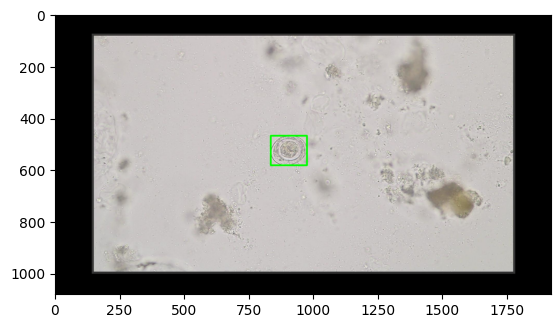

In [10]:
a = bestModel('./test/data/Hymenolepis nana_0727.jpg')
print(a[0].boxes.xywh)
xywh = a[0].boxes.xywh[0]
imgg = cv2.imread('./test/data/Hymenolepis nana_0727.jpg')
x,y,w,h = convertXcYcWH(*a[0].boxes.xywh[0])
cv2.rectangle(imgg, (int(x), int(y)), (int(x+w), int(y+h)), (0,255,0), 5)
imgg = cv2.cvtColor(imgg, cv2.COLOR_BGR2RGB)
plt.imshow(imgg)
plt.show()


### Submit Results

The results must follows this templates

{“annotations”: [
{“id”: int,
“file_name”: str,
“category_id”: int,
“bbox”: [x,y,width,height]}
]}



```
"categories": [
        {
            "id": 0,
            "name": "Capillaria philippinensis",
        },
        {
            "id": 1,
            "name": "Enterobius vermicularis",
        },
        {
            "id": 2,
            "name": "Hymenolepis diminuta",
        },
        {
            "id": 3,
            "name": "Hymenolepis nana",
        },
        {
            "id": 4,
            "name": "Paragonimus spp",
        }
    ]
```



In [11]:
## Sample annotations
annotations = dict()
annotations['annotations'] = list()
annotations['annotations'] += [{"id":2, "file_name":"Hymenolepis nana_0002.jpg","category_id":3,"bbox":[549.0,459.0,178.0,151.0]}]
annotations['annotations'] += [{"id":1, "file_name":"Hymenolepis nana_0052.jpg","category_id":3,"bbox":[539.0,364.0,218.0,215.0]}]

reserved = dict()

In [21]:
print(reserved.keys())

for i in reserved['annotations']:
    if i['file_name'].split()[1] == 'philippinensis_0752.jpg':
        print(i)

def findByFilename(filename):
    for i in reserved['annotations']:
        if i['file_name'] == filename:
            return i

dict_keys(['annotations'])
{'id': 71, 'file_name': 'Capillaria philippinensis_0752.jpg', 'category_id': 0.0, 'bbox': [1246.9608154296875, 1770.2435913085938, 141.427978515625, 102.5748291015625]}


In [23]:
# from mmdet.core import  bbox2result
import os
import numpy as np

image_dir = './test/data'

annotations = dict()
annotations['annotations'] = list()
id = 0
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):
        image_path = os.path.join(image_dir, filename)

        # print(image_path)

        ### run model
        result = bestModel(image_path, max_det=1)[0]
        if len(result.boxes) > 0:
            cat_id = list(result.boxes.cls.cpu().numpy().astype(np.double))[0]
            # bbox = list(result.boxes.xywh.cpu().numpy().astype(np.double)[0])
            bbox = list(convertXcYcWH(*result.boxes.xywh.cpu().numpy().astype(np.double)[0]))
        else:
            aaa = findByFilename(filename)
            cat_id = aaa['category_id']
            bbox = aaa['bbox']
            # print(filename)
            # print(cat_id)
            # print(bbox)
            # break
        coco_result = [{"id": id, "file_name": filename,"category_id": cat_id,"bbox":bbox}]
        id+=1

        annotations['annotations']+=coco_result
        # break


image 1/1 /home/andre/Desktop/CU_submission/chulacv2023/Lab9/student/test/data/Hymenolepis nana_0002.jpg: 864x1152 1 Hymenolepis nana, 17.3ms
Speed: 11.0ms preprocess, 17.3ms inference, 0.8ms postprocess per image at shape (1, 3, 864, 1152)

image 1/1 /home/andre/Desktop/CU_submission/chulacv2023/Lab9/student/test/data/Paragonimus spp_0677.jpg: 864x1152 1 Paragonimus spp, 17.7ms
Speed: 2.3ms preprocess, 17.7ms inference, 0.8ms postprocess per image at shape (1, 3, 864, 1152)

image 1/1 /home/andre/Desktop/CU_submission/chulacv2023/Lab9/student/test/data/Capillaria philippinensis_0177.jpg: 1152x864 1 Capillaria philippinensis, 17.4ms
Speed: 2.9ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 1152, 864)

image 1/1 /home/andre/Desktop/CU_submission/chulacv2023/Lab9/student/test/data/Capillaria philippinensis_0152.jpg: 1152x864 1 Capillaria philippinensis, 17.6ms
Speed: 3.0ms preprocess, 17.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1152, 864)



In [24]:
print(annotations)

{'annotations': [{'id': 0, 'file_name': 'Hymenolepis nana_0002.jpg', 'category_id': 3.0, 'bbox': [543.904052734375, 456.68531799316406, 183.2794189453125, 155.22775268554688]}, {'id': 1, 'file_name': 'Paragonimus spp_0677.jpg', 'category_id': 4.0, 'bbox': [552.4470825195312, 309.66650390625, 184.008544921875, 282.17083740234375]}, {'id': 2, 'file_name': 'Capillaria philippinensis_0177.jpg', 'category_id': 0.0, 'bbox': [921.6106872558594, 1721.7953491210938, 105.06500244140625, 137.9395751953125]}, {'id': 3, 'file_name': 'Capillaria philippinensis_0152.jpg', 'category_id': 0.0, 'bbox': [937.1592712402344, 1838.0429077148438, 117.01177978515625, 176.7506103515625]}, {'id': 4, 'file_name': 'Capillaria philippinensis_0077.jpg', 'category_id': 0.0, 'bbox': [1034.9384765625, 1699.78125, 184.946533203125, 97.0927734375]}, {'id': 5, 'file_name': 'Capillaria philippinensis_0977.jpg', 'category_id': 0.0, 'bbox': [953.5587463378906, 1782.837890625, 143.69964599609375, 124.29736328125]}, {'id': 6,

In [25]:
import requests
import json
sendDict = { 'studentID':'6432085221', 'results':  annotations }
# sendDict = json.dumps(sendDict)
response = requests.post('https://www.piclab.ai/classes/cv2023/lab9/scoreboard/submitLab9',headers={'Content-Type': 'application/json' }, json=sendDict)
print(response.text)

{"F1Score":1.0,"mAP0.5":1.0,"mAP0.5:0.95":0.9717542553238074,"mAP0.75":0.9898514851485148,"mIoU":0.9687762873272675,"status":"SUCCESS"}



In [15]:
reserved = {'annotations': [{'id': 0, 'file_name': 'Hymenolepis nana_0002.jpg', 'category_id': 3.0, 'bbox': [546.0891418457031, 458.96087646484375, 180.49505615234375, 152.04150390625]}, {'id': 1, 'file_name': 'Paragonimus spp_0677.jpg', 'category_id': 4.0, 'bbox': [551.1797790527344, 310.40721130371094, 185.44586181640625, 282.6562805175781]}, {'id': 2, 'file_name': 'Capillaria philippinensis_0177.jpg', 'category_id': 0.0, 'bbox': [922.1138916015625, 1722.66552734375, 105.544189453125, 137.830322265625]}, {'id': 3, 'file_name': 'Capillaria philippinensis_0152.jpg', 'category_id': 0.0, 'bbox': [936.3570251464844, 1838.002197265625, 116.89312744140625, 177.332275390625]}, {'id': 4, 'file_name': 'Capillaria philippinensis_0077.jpg', 'category_id': 0.0, 'bbox': [1035.1621704101562, 1701.1893310546875, 184.4217529296875, 94.20703125]}, {'id': 5, 'file_name': 'Capillaria philippinensis_0977.jpg', 'category_id': 0.0, 'bbox': [951.8955078125, 1783.0130004882812, 143.906982421875, 124.3055419921875]}, {'id': 6, 'file_name': 'Hymenolepis diminuta_0327.jpg', 'category_id': 2.0, 'bbox': [839.2748718261719, 423.3209533691406, 183.22637939453125, 183.85638427734375]}, {'id': 7, 'file_name': 'Capillaria philippinensis_0327.jpg', 'category_id': 0.0, 'bbox': [529.5424194335938, 458.9888153076172, 187.199951171875, 93.86880493164062]}, {'id': 8, 'file_name': 'Enterobius vermicularis_0677.jpg', 'category_id': 1.0, 'bbox': [893.8963928222656, 359.0933380126953, 107.15106201171875, 169.64083862304688]}, {'id': 9, 'file_name': 'Enterobius vermicularis_0702.jpg', 'category_id': 1.0, 'bbox': [939.916748046875, 488.6636657714844, 164.3265380859375, 94.89703369140625]}, {'id': 10, 'file_name': 'Paragonimus spp_0527.jpg', 'category_id': 4.0, 'bbox': [493.00584411621094, 421.15765380859375, 302.6332092285156, 176.36236572265625]}, {'id': 11, 'file_name': 'Enterobius vermicularis_0352.jpg', 'category_id': 1.0, 'bbox': [1056.498046875, 1663.3316040039062, 226.6005859375, 133.6810302734375]}, {'id': 12, 'file_name': 'Hymenolepis nana_0227.jpg', 'category_id': 3.0, 'bbox': [556.9277954101562, 402.4100341796875, 166.097412109375, 191.34356689453125]}, {'id': 13, 'file_name': 'Paragonimus spp_0577.jpg', 'category_id': 4.0, 'bbox': [557.5933837890625, 403.47251892089844, 187.9072265625, 298.9761047363281]}, {'id': 14, 'file_name': 'Hymenolepis nana_0402.jpg', 'category_id': 3.0, 'bbox': [1300.970703125, 2113.6627197265625, 267.8115234375, 216.819091796875]}, {'id': 15, 'file_name': 'Capillaria philippinensis_0377.jpg', 'category_id': 0.0, 'bbox': [634.4541320800781, 363.09368896484375, 195.39617919921875, 135.66656494140625]}, {'id': 16, 'file_name': 'Hymenolepis diminuta_0802.jpg', 'category_id': 2.0, 'bbox': [520.0672607421875, 333.57952880859375, 261.1396484375, 266.71484375]}, {'id': 17, 'file_name': 'Hymenolepis nana_0577.jpg', 'category_id': 3.0, 'bbox': [893.9351501464844, 467.1191864013672, 140.07891845703125, 119.19253540039062]}, {'id': 18, 'file_name': 'Hymenolepis nana_0827.jpg', 'category_id': 3.0, 'bbox': [1415.7517700195312, 2018.0244750976562, 229.9373779296875, 201.3773193359375]}, {'id': 19, 'file_name': 'Hymenolepis diminuta_0852.jpg', 'category_id': 2.0, 'bbox': [512.3702392578125, 346.17384338378906, 275.30029296875, 250.15158081054688]}, {'id': 20, 'file_name': 'Paragonimus spp_0702.jpg', 'category_id': 4.0, 'bbox': [575.0511779785156, 303.58714294433594, 196.12982177734375, 302.5536193847656]}, {'id': 21, 'file_name': 'Paragonimus spp_0927.jpg', 'category_id': 4.0, 'bbox': [1394.6345825195312, 1651.6276245117188, 234.4432373046875, 359.4151611328125]}, {'id': 22, 'file_name': 'Hymenolepis nana_0127.jpg', 'category_id': 3.0, 'bbox': [569.3583374023438, 361.55267333984375, 212.87451171875, 184.49005126953125]}, {'id': 23, 'file_name': 'Hymenolepis nana_0602.jpg', 'category_id': 3.0, 'bbox': [878.5988464355469, 469.5168151855469, 145.75762939453125, 122.95758056640625]}, {'id': 24, 'file_name': 'Hymenolepis nana_0352.jpg', 'category_id': 3.0, 'bbox': [1471.7089233398438, 2098.004638671875, 236.0181884765625, 316.41845703125]}, {'id': 25, 'file_name': 'Paragonimus spp_0552.jpg', 'category_id': 4.0, 'bbox': [484.1437072753906, 376.19970703125, 293.93231201171875, 212.760009765625]}, {'id': 26, 'file_name': 'Paragonimus spp_0227.jpg', 'category_id': 4.0, 'bbox': [870.4836120605469, 411.6326904296875, 154.93853759765625, 232.878173828125]}, {'id': 27, 'file_name': 'Hymenolepis diminuta_0127.jpg', 'category_id': 2.0, 'bbox': [1326.41357421875, 1870.0508422851562, 336.517578125, 338.7933349609375]}, {'id': 28, 'file_name': 'Hymenolepis nana_0302.jpg', 'category_id': 3.0, 'bbox': [1388.0989990234375, 2002.2493286132812, 199.33544921875, 214.0740966796875]}, {'id': 29, 'file_name': 'Capillaria philippinensis_0852.jpg', 'category_id': 0.0, 'bbox': [1419.4801025390625, 1864.0645141601562, 130.88818359375, 170.4295654296875]}, {'id': 30, 'file_name': 'Hymenolepis diminuta_0777.jpg', 'category_id': 2.0, 'bbox': [526.6186218261719, 349.4169921875, 278.20928955078125, 273.46875]}, {'id': 31, 'file_name': 'Hymenolepis diminuta_0577.jpg', 'category_id': 2.0, 'bbox': [1324.2900390625, 1685.26416015625, 408.33544921875, 394.3935546875]}, {'id': 32, 'file_name': 'Enterobius vermicularis_0852.jpg', 'category_id': 1.0, 'bbox': [1289.862548828125, 1624.7709350585938, 106.212646484375, 230.0699462890625]}, {'id': 33, 'file_name': 'Hymenolepis nana_0677.jpg', 'category_id': 3.0, 'bbox': [907.86474609375, 479.88258361816406, 125.862060546875, 124.97885131835938]}, {'id': 34, 'file_name': 'Hymenolepis diminuta_0102.jpg', 'category_id': 2.0, 'bbox': [1274.2266235351562, 1989.2080688476562, 321.8162841796875, 282.8402099609375]}, {'id': 35, 'file_name': 'Paragonimus spp_0102.jpg', 'category_id': 4.0, 'bbox': [843.9745178222656, 474.43634033203125, 178.90545654296875, 116.86572265625]}, {'id': 36, 'file_name': 'Hymenolepis nana_0952.jpg', 'category_id': 3.0, 'bbox': [1424.7809448242188, 2061.239013671875, 202.3878173828125, 240.62109375]}, {'id': 37, 'file_name': 'Hymenolepis diminuta_0477.jpg', 'category_id': 2.0, 'bbox': [867.8211975097656, 448.9434814453125, 188.02239990234375, 202.64208984375]}, {'id': 38, 'file_name': 'Hymenolepis diminuta_0427.jpg', 'category_id': 2.0, 'bbox': [794.691650390625, 437.79205322265625, 205.3839111328125, 190.8795166015625]}, {'id': 39, 'file_name': 'Paragonimus spp_0127.jpg', 'category_id': 4.0, 'bbox': [792.9606628417969, 448.2692565917969, 245.32012939453125, 158.34576416015625]}, {'id': 40, 'file_name': 'Capillaria philippinensis_0002.jpg', 'category_id': 1.0, 'bbox': [1087.3340454101562, 1646.8729248046875, 161.7967529296875, 105.3994140625]}, {'id': 41, 'file_name': 'Hymenolepis nana_0477.jpg', 'category_id': 3.0, 'bbox': [1290.0924682617188, 2097.2337646484375, 198.8858642578125, 204.180908203125]}, {'id': 42, 'file_name': 'Hymenolepis nana_0202.jpg', 'category_id': 3.0, 'bbox': [513.0841979980469, 436.6383819580078, 201.42657470703125, 189.67123413085938]}, {'id': 43, 'file_name': 'Paragonimus spp_0177.jpg', 'category_id': 4.0, 'bbox': [815.2755126953125, 441.03431701660156, 198.56884765625, 207.80477905273438]}, {'id': 44, 'file_name': 'Hymenolepis diminuta_0627.jpg', 'category_id': 2.0, 'bbox': [1359.659912109375, 1761.14990234375, 344.75390625, 346.31982421875]}, {'id': 45, 'file_name': 'Hymenolepis nana_0902.jpg', 'category_id': 3.0, 'bbox': [1461.1098022460938, 1948.6431274414062, 215.7618408203125, 259.1624755859375]}, {'id': 46, 'file_name': 'Paragonimus spp_0402.jpg', 'category_id': 4.0, 'bbox': [1441.006591796875, 1843.517822265625, 314.854248046875, 368.85009765625]}, {'id': 47, 'file_name': 'Enterobius vermicularis_0777.jpg', 'category_id': 1.0, 'bbox': [1177.769775390625, 1601.4920043945312, 208.5341796875, 128.3446044921875]}, {'id': 48, 'file_name': 'Hymenolepis diminuta_0402.jpg', 'category_id': 2.0, 'bbox': [922.8560485839844, 415.8765411376953, 190.82745361328125, 184.20223999023438]}, {'id': 49, 'file_name': 'Capillaria philippinensis_0427.jpg', 'category_id': 0.0, 'bbox': [542.9360656738281, 386.02687072753906, 108.66278076171875, 138.68905639648438]}, {'id': 50, 'file_name': 'Enterobius vermicularis_0627.jpg', 'category_id': 1.0, 'bbox': [936.6473388671875, 423.5605926513672, 101.0052490234375, 167.86233520507812]}, {'id': 51, 'file_name': 'Capillaria philippinensis_0727.jpg', 'category_id': 0.0, 'bbox': [871.877197265625, 487.8733673095703, 105.1937255859375, 92.15890502929688]}, {'id': 52, 'file_name': 'Enterobius vermicularis_0727.jpg', 'category_id': 1.0, 'bbox': [879.8685607910156, 458.9759979248047, 91.13934326171875, 164.56582641601562]}, {'id': 53, 'file_name': 'Hymenolepis nana_0877.jpg', 'category_id': 3.0, 'bbox': [1515.1010131835938, 1811.2682495117188, 220.3140869140625, 245.5323486328125]}, {'id': 54, 'file_name': 'Hymenolepis diminuta_0077.jpg', 'category_id': 2.0, 'bbox': [1341.197998046875, 1752.30517578125, 320.518798828125, 331.69091796875]}, {'id': 55, 'file_name': 'Capillaria philippinensis_0527.jpg', 'category_id': 0.0, 'bbox': [900.2872314453125, 489.7550811767578, 58.7276611328125, 110.37838745117188]}, {'id': 56, 'file_name': 'Hymenolepis nana_0502.jpg', 'category_id': 3.0, 'bbox': [1442.1072387695312, 1815.7924194335938, 192.6170654296875, 238.1119384765625]}, {'id': 57, 'file_name': 'Hymenolepis nana_0927.jpg', 'category_id': 3.0, 'bbox': [1385.3865356445312, 2021.803955078125, 222.3670654296875, 205.95361328125]}, {'id': 58, 'file_name': 'Capillaria philippinensis_0702.jpg', 'category_id': 0.0, 'bbox': [862.7560729980469, 474.9522247314453, 112.21783447265625, 95.37167358398438]}, {'id': 59, 'file_name': 'Hymenolepis diminuta_0677.jpg', 'category_id': 2.0, 'bbox': [1395.9722290039062, 1655.1817016601562, 317.1658935546875, 339.7982177734375]}, {'id': 60, 'file_name': 'Capillaria philippinensis_0277.jpg', 'category_id': 0.0, 'bbox': [583.7029418945312, 511.33631896972656, 137.18505859375, 152.38034057617188]}, {'id': 61, 'file_name': 'Paragonimus spp_0252.jpg', 'category_id': 4.0, 'bbox': [1359.5227661132812, 1952.4850463867188, 245.6326904296875, 435.0357666015625]}, {'id': 62, 'file_name': 'Hymenolepis nana_0702.jpg', 'category_id': 3.0, 'bbox': [844.8235778808594, 441.40411376953125, 131.36187744140625, 138.16119384765625]}, {'id': 63, 'file_name': 'Paragonimus spp_0902.jpg', 'category_id': 4.0, 'bbox': [1362.6879272460938, 1621.518798828125, 277.3741455078125, 476.839111328125]}, {'id': 64, 'file_name': 'Hymenolepis diminuta_0227.jpg', 'category_id': 2.0, 'bbox': [1473.9769897460938, 2120.4569091796875, 325.4014892578125, 323.303955078125]}, {'id': 65, 'file_name': 'Paragonimus spp_0602.jpg', 'category_id': 4.0, 'bbox': [511.0288848876953, 402.44195556640625, 325.7045593261719, 216.15789794921875]}, {'id': 66, 'file_name': 'Paragonimus spp_0002.jpg', 'category_id': 4.0, 'bbox': [813.1583557128906, 485.2406921386719, 236.49041748046875, 132.65728759765625]}, {'id': 67, 'file_name': 'Paragonimus spp_0327.jpg', 'category_id': 4.0, 'bbox': [1374.2221069335938, 1727.6959838867188, 270.2105712890625, 457.6778564453125]}, {'id': 68, 'file_name': 'Paragonimus spp_0152.jpg', 'category_id': 4.0, 'bbox': [823.69140625, 469.9235382080078, 218.1068115234375, 130.74398803710938]}, {'id': 69, 'file_name': 'Hymenolepis diminuta_0902.jpg', 'category_id': 2.0, 'bbox': [550.3973693847656, 318.8168182373047, 267.95574951171875, 284.4416809082031]}, {'id': 70, 'file_name': 'Hymenolepis nana_0727.jpg', 'category_id': 3.0, 'bbox': [832.7526550292969, 468.61572265625, 140.86798095703125, 115.721923828125]}, {'id': 71, 'file_name': 'Capillaria philippinensis_0752.jpg', 'category_id': 0.0, 'bbox': [1246.9608154296875, 1770.2435913085938, 141.427978515625, 102.5748291015625]}, {'id': 72, 'file_name': 'Hymenolepis diminuta_0877.jpg', 'category_id': 2.0, 'bbox': [507.5729675292969, 333.48960876464844, 278.63970947265625, 279.9756164550781]}, {'id': 73, 'file_name': 'Capillaria philippinensis_0827.jpg', 'category_id': 0.0, 'bbox': [1252.8590698242188, 1726.9920654296875, 181.0631103515625, 91.56689453125]}, {'id': 74, 'file_name': 'Capillaria philippinensis_0127.jpg', 'category_id': 0.0, 'bbox': [1354.3771362304688, 1732.6959838867188, 187.8048095703125, 138.6143798828125]}, {'id': 75, 'file_name': 'Enterobius vermicularis_0577.jpg', 'category_id': 1.0, 'bbox': [883.4775390625, 485.78038024902344, 138.118896484375, 131.17495727539062]}, {'id': 76, 'file_name': 'Paragonimus spp_0477.jpg', 'category_id': 4.0, 'bbox': [1439.1564331054688, 1844.7930908203125, 273.6309814453125, 410.609130859375]}, {'id': 77, 'file_name': 'Hymenolepis nana_0252.jpg', 'category_id': 3.0, 'bbox': [1342.9187622070312, 1726.589111328125, 210.9505615234375, 185.58203125]}, {'id': 78, 'file_name': 'Hymenolepis diminuta_0502.jpg', 'category_id': 2.0, 'bbox': [803.5484313964844, 442.4177551269531, 198.73614501953125, 195.39349365234375]}, {'id': 79, 'file_name': 'Capillaria philippinensis_0677.jpg', 'category_id': 0.0, 'bbox': [903.7168273925781, 474.3452453613281, 99.16912841796875, 96.49310302734375]}, {'id': 80, 'file_name': 'Capillaria philippinensis_0552.jpg', 'category_id': 0.0, 'bbox': [1049.280029296875, 552.4392395019531, 65.679931640625, 117.43914794921875]}, {'id': 81, 'file_name': 'Hymenolepis nana_0102.jpg', 'category_id': 3.0, 'bbox': [517.603271484375, 447.44569396972656, 189.638671875, 202.66427612304688]}, {'id': 82, 'file_name': 'Enterobius vermicularis_0977.jpg', 'category_id': 1.0, 'bbox': [1217.3896484375, 1684.372314453125, 109.99462890625, 227.62890625]}, {'id': 83, 'file_name': 'Hymenolepis diminuta_0527.jpg', 'category_id': 2.0, 'bbox': [1366.9402465820312, 1678.9522094726562, 352.9427490234375, 344.6859130859375]}, {'id': 84, 'file_name': 'Paragonimus spp_0777.jpg', 'category_id': 4.0, 'bbox': [1402.9718627929688, 1864.47021484375, 370.4063720703125, 220.121337890625]}, {'id': 85, 'file_name': 'Hymenolepis nana_0527.jpg', 'category_id': 3.0, 'bbox': [836.1768493652344, 438.61962890625, 115.16387939453125, 132.04083251953125]}, {'id': 86, 'file_name': 'Hymenolepis nana_0377.jpg', 'category_id': 3.0, 'bbox': [1385.1964111328125, 2015.1031494140625, 214.68994140625, 227.789794921875]}, {'id': 87, 'file_name': 'Hymenolepis diminuta_0352.jpg', 'category_id': 2.0, 'bbox': [831.1199035644531, 393.44012451171875, 207.27215576171875, 209.74688720703125]}, {'id': 88, 'file_name': 'Capillaria philippinensis_0102.jpg', 'category_id': 0.0, 'bbox': [956.3392944335938, 1773.9985961914062, 143.5816650390625, 107.7752685546875]}, {'id': 89, 'file_name': 'Enterobius vermicularis_0227.jpg', 'category_id': 1.0, 'bbox': [513.9091796875, 425.4466094970703, 230.77734375, 130.51132202148438]}, {'id': 90, 'file_name': 'Paragonimus spp_0627.jpg', 'category_id': 4.0, 'bbox': [482.2071075439453, 416.4603271484375, 347.5469665527344, 229.126953125]}, {'id': 91, 'file_name': 'Paragonimus spp_0202.jpg', 'category_id': 4.0, 'bbox': [877.1669006347656, 420.75042724609375, 130.67791748046875, 204.0714111328125]}, {'id': 92, 'file_name': 'Capillaria philippinensis_0027.jpg', 'category_id': 0.0, 'bbox': [1169.2915649414062, 1744.5179443359375, 138.0867919921875, 153.58544921875]}, {'id': 93, 'file_name': 'Hymenolepis diminuta_0027.jpg', 'category_id': 2.0, 'bbox': [1288.3596801757812, 1707.4710693359375, 317.2142333984375, 336.646728515625]}, {'id': 94, 'file_name': 'Capillaria philippinensis_0052.jpg', 'category_id': 0.0, 'bbox': [1244.171875, 1592.7216796875, 87.14794921875, 170.015869140625]}, {'id': 95, 'file_name': 'Capillaria philippinensis_0402.jpg', 'category_id': 0.0, 'bbox': [557.0763244628906, 506.00978088378906, 115.20648193359375, 167.11996459960938]}, {'id': 96, 'file_name': 'Hymenolepis nana_0052.jpg', 'category_id': 3.0, 'bbox': [540.2160949707031, 364.5954132080078, 216.92889404296875, 214.60055541992188]}, {'id': 97, 'file_name': 'Hymenolepis diminuta_0727.jpg', 'category_id': 2.0, 'bbox': [1413.4879760742188, 1840.8053588867188, 318.5133056640625, 319.2808837890625]}, {'id': 98, 'file_name': 'Capillaria philippinensis_0252.jpg', 'category_id': 0.0, 'bbox': [621.552734375, 407.21112060546875, 169.8958740234375, 112.77154541015625]}, {'id': 99, 'file_name': 'Capillaria philippinensis_0652.jpg', 'category_id': 0.0, 'bbox': [970.7887878417969, 516.3014831542969, 90.57818603515625, 124.41192626953125]}, {'id': 100, 'file_name': 'Enterobius vermicularis_0002.jpg', 'category_id': 1.0, 'bbox': [598.2869567871094, 463.56224060058594, 235.77203369140625, 134.20681762695312]}, {'id': 101, 'file_name': 'Hymenolepis diminuta_0952.jpg', 'category_id': 2.0, 'bbox': [526.5888671875, 335.1417694091797, 262.39404296875, 255.90603637695312]}, {'id': 102, 'file_name': 'Enterobius vermicularis_0052.jpg', 'category_id': 1.0, 'bbox': [491.8432312011719, 284.8827362060547, 224.66094970703125, 168.39065551757812]}, {'id': 103, 'file_name': 'Hymenolepis diminuta_0302.jpg', 'category_id': 2.0, 'bbox': [834.8202514648438, 439.1637878417969, 189.0115966796875, 189.00469970703125]}, {'id': 104, 'file_name': 'Hymenolepis nana_0327.jpg', 'category_id': 3.0, 'bbox': [1336.6574096679688, 2109.720703125, 236.2486572265625, 207.2666015625]}, {'id': 105, 'file_name': 'Paragonimus spp_0977.jpg', 'category_id': 4.0, 'bbox': [1366.0807495117188, 1667.6762084960938, 332.8355712890625, 363.6129150390625]}, {'id': 106, 'file_name': 'Enterobius vermicularis_0527.jpg', 'category_id': 1.0, 'bbox': [851.3395080566406, 463.8682861328125, 156.66546630859375, 100.9893798828125]}, {'id': 107, 'file_name': 'Hymenolepis nana_0777.jpg', 'category_id': 3.0, 'bbox': [1365.3342895507812, 2090.8050537109375, 211.1541748046875, 207.711181640625]}, {'id': 108, 'file_name': 'Capillaria philippinensis_0502.jpg', 'category_id': 0.0, 'bbox': [921.366943359375, 518.7104187011719, 104.7073974609375, 79.75567626953125]}, {'id': 109, 'file_name': 'Enterobius vermicularis_0152.jpg', 'category_id': 1.0, 'bbox': [499.9256591796875, 282.9827880859375, 180.080078125, 196.06915283203125]}, {'id': 110, 'file_name': 'Enterobius vermicularis_0802.jpg', 'category_id': 1.0, 'bbox': [1171.90625, 1574.3770141601562, 236.258544921875, 113.3201904296875]}, {'id': 111, 'file_name': 'Enterobius vermicularis_0477.jpg', 'category_id': 1.0, 'bbox': [1074.8538818359375, 1717.1728515625, 226.375732421875, 133.123779296875]}, {'id': 112, 'file_name': 'Enterobius vermicularis_0602.jpg', 'category_id': 1.0, 'bbox': [966.9356384277344, 465.9687805175781, 83.73614501953125, 173.08978271484375]}, {'id': 113, 'file_name': 'Paragonimus spp_0752.jpg', 'category_id': 4.0, 'bbox': [518.2637939453125, 371.0529022216797, 303.08837890625, 265.4856262207031]}, {'id': 114, 'file_name': 'Paragonimus spp_0427.jpg', 'category_id': 4.0, 'bbox': [1331.9462890625, 1733.5957641601562, 341.129150390625, 372.2376708984375]}, {'id': 115, 'file_name': 'Paragonimus spp_0452.jpg', 'category_id': 4.0, 'bbox': [1484.7203369140625, 1818.5455932617188, 228.29443359375, 354.3082275390625]}, {'id': 116, 'file_name': 'Capillaria philippinensis_0577.jpg', 'category_id': 0.0, 'bbox': [918.671142578125, 513.7661743164062, 129.5487060546875, 69.8441162109375]}, {'id': 117, 'file_name': 'Hymenolepis diminuta_0552.jpg', 'category_id': 2.0, 'bbox': [1320.30908203125, 1641.1431884765625, 339.303466796875, 349.21630859375]}, {'id': 118, 'file_name': 'Enterobius vermicularis_0452.jpg', 'category_id': 1.0, 'bbox': [1197.7816162109375, 1397.18212890625, 141.715087890625, 225.694091796875]}, {'id': 119, 'file_name': 'Enterobius vermicularis_0877.jpg', 'category_id': 1.0, 'bbox': [1274.6144409179688, 1757.2120971679688, 146.4918212890625, 219.7711181640625]}, {'id': 120, 'file_name': 'Capillaria philippinensis_0802.jpg', 'category_id': 0.0, 'bbox': [1331.9449462890625, 1775.9025268554688, 88.075439453125, 164.3756103515625]}, {'id': 121, 'file_name': 'Hymenolepis diminuta_0827.jpg', 'category_id': 2.0, 'bbox': [528.9661865234375, 332.77833557128906, 271.375732421875, 278.0894470214844]}, {'id': 122, 'file_name': 'Enterobius vermicularis_0077.jpg', 'category_id': 1.0, 'bbox': [539.8402404785156, 339.9803924560547, 249.89398193359375, 120.92056274414062]}, {'id': 123, 'file_name': 'Hymenolepis nana_0977.jpg', 'category_id': 3.0, 'bbox': [1528.087158203125, 1927.857666015625, 206.1875, 214.68359375]}, {'id': 124, 'file_name': 'Enterobius vermicularis_0202.jpg', 'category_id': 1.0, 'bbox': [674.8751525878906, 255.97344207763672, 151.69989013671875, 236.2296905517578]}, {'id': 125, 'file_name': 'Capillaria philippinensis_0452.jpg', 'category_id': 0.0, 'bbox': [484.36219787597656, 437.54364013671875, 137.30258178710938, 150.7977294921875]}, {'id': 126, 'file_name': 'Paragonimus spp_0802.jpg', 'category_id': 4.0, 'bbox': [1366.6458740234375, 1851.999755859375, 294.006591796875, 338.872802734375]}, {'id': 127, 'file_name': 'Enterobius vermicularis_0402.jpg', 'category_id': 1.0, 'bbox': [1215.957763671875, 1844.1859741210938, 157.9873046875, 216.2139892578125]}, {'id': 128, 'file_name': 'Paragonimus spp_0652.jpg', 'category_id': 4.0, 'bbox': [515.6825866699219, 363.92408752441406, 302.14190673828125, 201.12985229492188]}, {'id': 129, 'file_name': 'Paragonimus spp_0352.jpg', 'category_id': 4.0, 'bbox': [1405.7918701171875, 1931.357666015625, 314.904541015625, 204.56884765625]}, {'id': 130, 'file_name': 'Hymenolepis diminuta_0152.jpg', 'category_id': 2.0, 'bbox': [1436.8235473632812, 1933.4025268554688, 290.6068115234375, 293.6993408203125]}, {'id': 131, 'file_name': 'Hymenolepis nana_0427.jpg', 'category_id': 3.0, 'bbox': [1298.783203125, 2047.6614990234375, 253.768310546875, 204.338134765625]}, {'id': 132, 'file_name': 'Enterobius vermicularis_0102.jpg', 'category_id': 1.0, 'bbox': [504.1807556152344, 360.4705352783203, 231.82061767578125, 134.34408569335938]}, {'id': 133, 'file_name': 'Enterobius vermicularis_0927.jpg', 'category_id': 1.0, 'bbox': [1030.0210571289062, 1513.8447265625, 152.3919677734375, 244.6015625]}, {'id': 134, 'file_name': 'Hymenolepis nana_0452.jpg', 'category_id': 3.0, 'bbox': [1337.95849609375, 1961.8699951171875, 234.247802734375, 247.398681640625]}, {'id': 135, 'file_name': 'Paragonimus spp_0952.jpg', 'category_id': 4.0, 'bbox': [1422.5521240234375, 1649.566162109375, 236.637451171875, 380.343994140625]}, {'id': 136, 'file_name': 'Capillaria philippinensis_0877.jpg', 'category_id': 0.0, 'bbox': [1094.6103515625, 1847.2000732421875, 172.545166015625, 99.41162109375]}, {'id': 137, 'file_name': 'Capillaria philippinensis_0902.jpg', 'category_id': 0.0, 'bbox': [1295.9906005859375, 1814.174072265625, 117.985107421875, 174.301513671875]}, {'id': 138, 'file_name': 'Enterobius vermicularis_0652.jpg', 'category_id': 1.0, 'bbox': [988.4271545410156, 509.3906707763672, 147.04241943359375, 126.82351684570312]}, {'id': 139, 'file_name': 'Hymenolepis nana_0852.jpg', 'category_id': 3.0, 'bbox': [1452.365478515625, 2070.2630615234375, 222.16455078125, 204.550048828125]}, {'id': 140, 'file_name': 'Hymenolepis diminuta_0602.jpg', 'category_id': 2.0, 'bbox': [1381.21435546875, 1869.816162109375, 322.41650390625, 315.979248046875]}, {'id': 141, 'file_name': 'Paragonimus spp_0077.jpg', 'category_id': 4.0, 'bbox': [843.1130981445312, 403.4092712402344, 156.1407470703125, 259.87628173828125]}, {'id': 142, 'file_name': 'Hymenolepis nana_0077.jpg', 'category_id': 3.0, 'bbox': [472.1403503417969, 409.87652587890625, 159.63897705078125, 193.0738525390625]}, {'id': 143, 'file_name': 'Enterobius vermicularis_0902.jpg', 'category_id': 1.0, 'bbox': [1259.8878173828125, 1920.489501953125, 214.1259765625, 179.5458984375]}, {'id': 144, 'file_name': 'Hymenolepis nana_0552.jpg', 'category_id': 3.0, 'bbox': [848.92919921875, 518.5942077636719, 130.0032958984375, 112.27154541015625]}, {'id': 145, 'file_name': 'Capillaria philippinensis_0627.jpg', 'category_id': 0.0, 'bbox': [798.5204162597656, 472.4585723876953, 113.67694091796875, 65.64718627929688]}, {'id': 146, 'file_name': 'Enterobius vermicularis_0027.jpg', 'category_id': 1.0, 'bbox': [454.7096710205078, 301.22674560546875, 228.06845092773438, 164.02642822265625]}, {'id': 147, 'file_name': 'Enterobius vermicularis_0952.jpg', 'category_id': 1.0, 'bbox': [1272.4923095703125, 1634.6541748046875, 229.853759765625, 133.70751953125]}, {'id': 148, 'file_name': 'Capillaria philippinensis_0302.jpg', 'category_id': 0.0, 'bbox': [582.6686096191406, 322.8803405761719, 97.53387451171875, 176.37872314453125]}, {'id': 149, 'file_name': 'Hymenolepis diminuta_0652.jpg', 'category_id': 2.0, 'bbox': [1350.5263671875, 1731.091064453125, 344.06494140625, 347.731201171875]}, {'id': 150, 'file_name': 'Hymenolepis nana_0027.jpg', 'category_id': 3.0, 'bbox': [500.17152404785156, 368.61354064941406, 178.46908569335938, 168.84347534179688]}, {'id': 151, 'file_name': 'Enterobius vermicularis_0827.jpg', 'category_id': 1.0, 'bbox': [1166.6232299804688, 1617.469970703125, 190.4342041015625, 159.636474609375]}, {'id': 152, 'file_name': 'Paragonimus spp_0852.jpg', 'category_id': 4.0, 'bbox': [1351.3633422851562, 1761.2930297851562, 400.2962646484375, 263.1668701171875]}, {'id': 153, 'file_name': 'Paragonimus spp_0052.jpg', 'category_id': 4.0, 'bbox': [811.000732421875, 504.1040802001953, 231.86279296875, 141.76657104492188]}, {'id': 154, 'file_name': 'Paragonimus spp_0877.jpg', 'category_id': 4.0, 'bbox': [1323.970458984375, 1795.05810546875, 409.5400390625, 298.59619140625]}, {'id': 155, 'file_name': 'Hymenolepis nana_0627.jpg', 'category_id': 3.0, 'bbox': [864.3189086914062, 488.82606506347656, 121.46240234375, 125.18307495117188]}, {'id': 156, 'file_name': 'Hymenolepis diminuta_0002.jpg', 'category_id': 2.0, 'bbox': [1300.9736938476562, 2131.042724609375, 344.4979248046875, 315.333984375]}, {'id': 157, 'file_name': 'Hymenolepis diminuta_0702.jpg', 'category_id': 2.0, 'bbox': [1358.18212890625, 1820.43310546875, 348.796875, 336.287109375]}, {'id': 158, 'file_name': 'Paragonimus spp_0827.jpg', 'category_id': 4.0, 'bbox': [1308.176025390625, 1811.265625, 393.5341796875, 288.2861328125]}, {'id': 159, 'file_name': 'Hymenolepis diminuta_0177.jpg', 'category_id': 2.0, 'bbox': [1359.7529296875, 2022.6340942382812, 311.986572265625, 313.8763427734375]}, {'id': 160, 'file_name': 'Hymenolepis nana_0802.jpg', 'category_id': 3.0, 'bbox': [1332.200439453125, 2091.6072998046875, 213.361083984375, 202.527587890625]}, {'id': 161, 'file_name': 'Hymenolepis diminuta_0252.jpg', 'category_id': 2.0, 'bbox': [1193.3191528320312, 1984.3540649414062, 362.7869873046875, 354.8929443359375]}, {'id': 162, 'file_name': 'Hymenolepis diminuta_0977.jpg', 'category_id': 2.0, 'bbox': [536.9329223632812, 367.11134338378906, 264.7618408203125, 262.1540222167969]}, {'id': 163, 'file_name': 'Enterobius vermicularis_0752.jpg', 'category_id': 1.0, 'bbox': [1176.1466674804688, 1633.4536743164062, 228.7374267578125, 115.3870849609375]}, {'id': 164, 'file_name': 'Hymenolepis diminuta_0452.jpg', 'category_id': 2.0, 'bbox': [838.668212890625, 433.6301727294922, 194.759033203125, 190.11697387695312]}, {'id': 165, 'file_name': 'Enterobius vermicularis_0502.jpg', 'category_id': 1.0, 'bbox': [867.2438049316406, 458.12835693359375, 161.90228271484375, 89.48992919921875]}, {'id': 166, 'file_name': 'Capillaria philippinensis_0927.jpg', 'category_id': 0.0, 'bbox': [1192.6373901367188, 1746.5306396484375, 148.8829345703125, 127.093994140625]}, {'id': 167, 'file_name': 'Paragonimus spp_0502.jpg', 'category_id': 4.0, 'bbox': [485.5169372558594, 350.47999572753906, 340.20855712890625, 235.27999877929688]}, {'id': 168, 'file_name': 'Enterobius vermicularis_0302.jpg', 'category_id': 1.0, 'bbox': [1135.6954345703125, 1599.15966796875, 206.645263671875, 167.41357421875]}, {'id': 169, 'file_name': 'Hymenolepis nana_0652.jpg', 'category_id': 3.0, 'bbox': [881.8323669433594, 443.9240264892578, 141.02642822265625, 120.50717163085938]}, {'id': 170, 'file_name': 'Capillaria philippinensis_0227.jpg', 'category_id': 0.0, 'bbox': [1202.9440307617188, 1867.3253173828125, 135.9293212890625, 147.889892578125]}, {'id': 171, 'file_name': 'Capillaria philippinensis_0202.jpg', 'category_id': 0.0, 'bbox': [1116.2234497070312, 1744.619384765625, 136.0169677734375, 150.25390625]}, {'id': 172, 'file_name': 'Enterobius vermicularis_0377.jpg', 'category_id': 1.0, 'bbox': [1076.8567504882812, 1603.1810302734375, 185.8939208984375, 179.209716796875]}, {'id': 173, 'file_name': 'Capillaria philippinensis_0952.jpg', 'category_id': 0.0, 'bbox': [1089.7714233398438, 1778.3013305664062, 151.9537353515625, 121.8626708984375]}, {'id': 174, 'file_name': 'Hymenolepis nana_0752.jpg', 'category_id': 3.0, 'bbox': [801.2457580566406, 432.486572265625, 134.42523193359375, 128.725341796875]}, {'id': 175, 'file_name': 'Capillaria philippinensis_0477.jpg', 'category_id': 0.0, 'bbox': [684.3358154296875, 519.0194702148438, 129.0926513671875, 139.21875]}, {'id': 176, 'file_name': 'Enterobius vermicularis_0127.jpg', 'category_id': 1.0, 'bbox': [589.2544860839844, 364.2354736328125, 198.00860595703125, 179.61932373046875]}, {'id': 177, 'file_name': 'Hymenolepis nana_0177.jpg', 'category_id': 3.0, 'bbox': [506.01438903808594, 379.3455810546875, 196.22366333007812, 167.05023193359375]}, {'id': 178, 'file_name': 'Enterobius vermicularis_0177.jpg', 'category_id': 1.0, 'bbox': [642.2536010742188, 327.5466766357422, 231.2144775390625, 147.74417114257812]}, {'id': 179, 'file_name': 'Hymenolepis nana_0277.jpg', 'category_id': 3.0, 'bbox': [1368.490234375, 2148.696044921875, 229.7353515625, 212.8671875]}, {'id': 180, 'file_name': 'Enterobius vermicularis_0552.jpg', 'category_id': 1.0, 'bbox': [919.52001953125, 484.8625183105469, 177.79443359375, 82.41241455078125]}, {'id': 181, 'file_name': 'Enterobius vermicularis_0427.jpg', 'category_id': 1.0, 'bbox': [1316.625732421875, 1610.8527221679688, 233.783935546875, 148.9727783203125]}, {'id': 182, 'file_name': 'Hymenolepis diminuta_0377.jpg', 'category_id': 2.0, 'bbox': [836.7783203125, 402.61004638671875, 194.2626953125, 206.67095947265625]}, {'id': 183, 'file_name': 'Capillaria philippinensis_0777.jpg', 'category_id': 0.0, 'bbox': [1056.8900756835938, 1833.6759033203125, 80.1510009765625, 151.69677734375]}, {'id': 184, 'file_name': 'Hymenolepis diminuta_0752.jpg', 'category_id': 2.0, 'bbox': [1431.10400390625, 1672.7252807617188, 326.2861328125, 333.4317626953125]}, {'id': 185, 'file_name': 'Paragonimus spp_0727.jpg', 'category_id': 4.0, 'bbox': [518.4685974121094, 337.31761169433594, 266.78717041015625, 290.4386291503906]}, {'id': 186, 'file_name': 'Enterobius vermicularis_0252.jpg', 'category_id': 1.0, 'bbox': [1129.4960327148438, 1570.8667602539062, 221.2022705078125, 130.8333740234375]}, {'id': 187, 'file_name': 'Enterobius vermicularis_0327.jpg', 'category_id': 1.0, 'bbox': [1063.071044921875, 1758.58544921875, 244.828369140625, 118.954345703125]}, {'id': 188, 'file_name': 'Capillaria philippinensis_0352.jpg', 'category_id': 0.0, 'bbox': [525.3389587402344, 414.0751953125, 145.51348876953125, 111.3399658203125]}, {'id': 189, 'file_name': 'Paragonimus spp_0277.jpg', 'category_id': 4.0, 'bbox': [1377.2520751953125, 1873.1589965820312, 326.687744140625, 314.3240966796875]}, {'id': 190, 'file_name': 'Paragonimus spp_0302.jpg', 'category_id': 4.0, 'bbox': [1359.8234252929688, 1972.31005859375, 414.9747314453125, 248.0927734375]}, {'id': 191, 'file_name': 'Hymenolepis nana_0152.jpg', 'category_id': 3.0, 'bbox': [530.6758728027344, 405.00563049316406, 154.85601806640625, 186.22775268554688]}, {'id': 192, 'file_name': 'Enterobius vermicularis_0277.jpg', 'category_id': 1.0, 'bbox': [1038.5955810546875, 1680.071533203125, 209.9755859375, 158.374755859375]}, {'id': 193, 'file_name': 'Capillaria philippinensis_0602.jpg', 'category_id': 0.0, 'bbox': [1005.5221557617188, 498.11134338378906, 99.6358642578125, 124.13034057617188]}, {'id': 194, 'file_name': 'Hymenolepis diminuta_0202.jpg', 'category_id': 2.0, 'bbox': [1330.2007446289062, 2112.0526123046875, 339.2244873046875, 358.726806640625]}, {'id': 195, 'file_name': 'Hymenolepis diminuta_0277.jpg', 'category_id': 2.0, 'bbox': [816.6551818847656, 398.31166076660156, 181.10638427734375, 184.88583374023438]}, {'id': 196, 'file_name': 'Paragonimus spp_0377.jpg', 'category_id': 4.0, 'bbox': [1313.38671875, 1916.4425659179688, 424.76416015625, 275.2901611328125]}, {'id': 197, 'file_name': 'Paragonimus spp_0027.jpg', 'category_id': 4.0, 'bbox': [838.7292175292969, 464.24720764160156, 184.58502197265625, 179.77743530273438]}, {'id': 198, 'file_name': 'Hymenolepis diminuta_0052.jpg', 'category_id': 2.0, 'bbox': [1327.2196044921875, 1864.9718627929688, 325.201171875, 339.6461181640625]}, {'id': 199, 'file_name': 'Hymenolepis diminuta_0927.jpg', 'category_id': 2.0, 'bbox': [542.3879699707031, 356.61036682128906, 273.81512451171875, 261.6940612792969]}]}
